# Exercise 7: Encoder

Copy the data loading, vectorization and `SelfAttention` implementation from the previous exercises.

In [ ]:
tokens2idx = {TOK_1: 0, TOK_2: 1, TOK_3: 2, TOK_4: 3}
    init_index = len(tokens2idx)

    # map each vocab token to a unique index
    for i, token in enumerate(vocab):
        tokens2idx[token] = i + init_index
    # build inverse mapping
    index_2_token = {idx: tok for tok, idx in tokens_2_index_dict.items()}

    # compute vocab size
    vocab_size = len(tokens_2_index_dict)

    # convert sentences to lists of token indices
    sentences_2_tokens_lst = []
    for sentence in sentences:
        lst_temporal = []
        for word in sentence.split():
            lst_temporal.append(tokens_2_index_dict[word])
        sentences_2_tokens_lst.append(lst_temporal)

    return tokens_2_index_dict, index_2_token, vocab_size, sentences_2_tokens_lst

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from gensim.downloader import load as gensim_load
from datasets import load_dataset, concatenate_datasets

## C.1 Multi-Head Attention

In [116]:
# You can reuse the `SelfAttention` class from Exercise 6, but you might need to extend it to support masking (C.1.1.v).
class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k):
        super().__init__()
        # define the weight matrices W_Q, W_K, and W_V
        self.model = d_model
        self.d_k = d_k

        # learnable weight matrices
        self.W_Q = nn.Linear(d_model, d_k) #x @ weight + bias
        self.W_K = nn.Linear(d_model, d_k) #x @ weight + bias
        self.W_V = nn.Linear(d_model, d_k) #....


    def forward(self, x, mask=None):
        #vector production
        W_Q = self.W_Q(x)
        W_K = self.W_K(x)
        W_V = self.W_V(x)
         
        #attention score using dot product between queries and keys
        scores = torch.matmul (W_Q, W_K.transpose(-2,-1)) / np.sqrt(self.d_k)

        if mask is not None: 
            #adding minus infinity to masked values (with 0 zero) to nullify after softmax
            #-1e9
            mask = mask.unsqueeze(1)
            scores= scores.masked_fill(mask ==0, float('-inf'))
        W_attention = F.softmax(scores, dim=-1)
        #attention-weighted sum of the value vector
        out = torch.matmul(W_attention, W_V)
        return out

In [117]:
# C.1.1 Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.n_heads = n_heads


        #concatination (head_1, head_2,... head_n)

        self.heads = nn.ModuleList(
            [SelfAttention(d_model, d_k) for _ in range (n_heads) ]
        )
        #linear projection/ dense layer
        self.proj = nn.Linear(n_heads * d_k, d_model)

    def forward(self, x, mask=None):

        head_output = []

        #calling forward for each self-attention 
        for head in self.heads: 
            out = head(x, mask= mask)
            head_output.append(out)
        concat = torch.cat(head_output, dim =-1)

        return self.proj(concat)
    

In [118]:
# C.1.2 Add Residual Connection and LayerNorm
class MultiHeadBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads, d_k )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_out = self.attn(x, mask)
        # input = x + atten_out residual connection
        return self.norm(x + attn_out)
    

## C.2 Feed-Forward Network

In [119]:
# C.2.1 Point-wise Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.activation(self.linear1(x)))

In [120]:
# C.2 
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.ffn = FeedForward(d_model, d_ff)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        return self.norm(x + self.ffn(x))

## Task 3: Encoder Block and Sentiment Classifier

In [121]:
# Implement the Encoder Block, i.e., the combination of MultiHeadBlock and FeedForwardBlock
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k=None):
        super().__init__()
        self.attn_block = MultiHeadBlock(d_model, n_heads, d_k)
        self.ffn_block = FeedForwardBlock(d_model, d_ff)

    def forward(self, x, mask=None):
        #adding self attention to each token
        x = self.attn_block(x, mask)
        #adds non-linear processing for each token
        #original information is tracked using residual connection 
        x = self.ffn_block(x)
        return x

In [122]:
class SentimentClassifier(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k=None, num_classes=2):
        super().__init__()
        self.encoder = EncoderBlock(d_model, n_heads, d_ff, d_k)
        self.pool = nn.AdaptiveAvgPool1d(1)  # avergae pooling to get a summary of vectors
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        #what's the use of the encoder here if i'm only adding one encoder block?
        x = self.encoder(x, mask)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)
    
#same classifier but with multiple encoder blocks
class SentimentClassifier_MB(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k=None, num_classes=2):
        super().__init__()
        
        # two encoder blocks
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(d_model, n_heads, d_ff, d_k),
            EncoderBlock(d_model, n_heads, d_ff, d_k)
        ])
        
        self.pool = nn.AdaptiveAvgPool1d(1)  
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        for block in self.encoder_blocks:
            x = block(x, mask)  

        x = x.transpose(1, 2) 
        print(x.shape)         
        x = self.pool(x).squeeze(-1)     
        return self.classifier(x)

## Task 4: Data Preparation (same as in Exercise 6)

In [123]:
glove = gensim_load('glove-wiki-gigaword-100')

In [124]:
def load_imdb(n_samples=100):
    dataset = load_dataset("imdb", split="train")

    # How many samples per class
    n_per_class = n_samples // 2

    # Filter each class
    pos = dataset.filter(lambda x: x["label"] == 1).shuffle(seed=42).select(range(n_per_class))
    neg = dataset.filter(lambda x: x["label"] == 0).shuffle(seed=42).select(range(n_per_class))
    
    # Combine and shuffle
    balanced = concatenate_datasets([pos, neg]).shuffle(seed=42)

    texts = balanced["text"]
    labels = balanced["label"]
    return texts, labels

texts, labels = load_imdb(n_samples=10000)

In [125]:
def tokenize(text):
    return [w.lower() for w in text.split() if w.isalpha()]

In [126]:
def vectorize(tokens, max_len=128):
    embed_dim = glove.vector_size
    vecs = []
    for token in tokens[:max_len]:
        vec = glove[token] if token in glove else np.zeros(embed_dim)
        vecs.append(vec)
    while len(vecs) < max_len:
        vecs.append(np.zeros(embed_dim))
    return np.array(vecs)

In [127]:
# Create X and y
max_len = 128
X = np.stack([
    vectorize(tokenize(text), max_len)
    for text in texts
])
y = np.array(labels)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

from collections import Counter
print(Counter(labels))  


Counter({0: 5000, 1: 5000})


## Task 5: Training

In [128]:
# Chose your model parameters
# Remember the rules of thumb:
# - d_ff = 4*d_model
# - d_k = d_model // n_heads 

d_model = 100 # todo # can you chose any number here? no. should be the same size as mmy input (vectorized embeddings)
n_heads = 10 # todo
d_ff = 4 * d_model # todo
d_k = d_model // n_heads# todo

In [129]:
# define the model, loss, optimizer
# todo


model = SentimentClassifier(d_model=d_model, n_heads=n_heads, d_ff=d_ff, d_k=d_k, num_classes=2)
# classifier with n_class so crossentropy would work. should I have used softmax here? would difference would it make?
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [130]:
# print the total parameter count of the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

bert_base_params = 110_000_000  # BERT base model has ~110M parameters
gpt_4_params = 1_700_000_000_000  # GPT-4 has ~1.7T parameters
print(f"Model parameters relative to BERT base: {100 * total_params / bert_base_params:.6f}%")
print(f"Model parameters relative to GPT-4: {100 * total_params / gpt_4_params:.6f}%")

Total trainable parameters: 121,502
Model parameters relative to BERT base: 0.110456%
Model parameters relative to GPT-4: 0.000007%


Epoch 1 : loss = 0.6680
Epoch 2 : loss = 0.5575
Epoch 3 : loss = 0.4967
Epoch 4 : loss = 0.4750
Epoch 5 : loss = 0.4613
Epoch 6 : loss = 0.4516
Epoch 7 : loss = 0.4446
Epoch 8 : loss = 0.4376
Epoch 9 : loss = 0.4329
Epoch 10 : loss = 0.4274


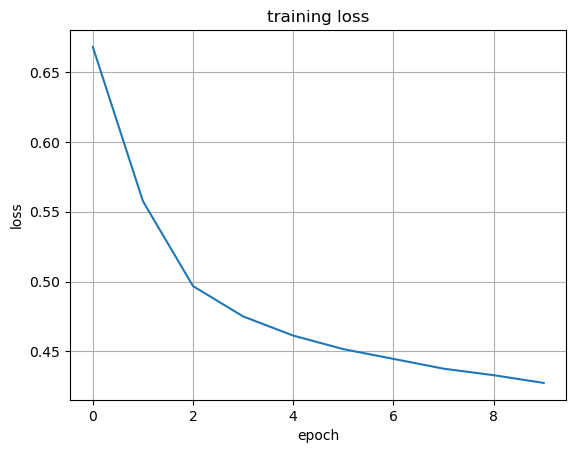

In [131]:
# define the training loop
import matplotlib.pyplot as plt

def train_model(model, X, y, num_epochs=5, batch_size=32,device='cuda'):
    model.to(device)
    X, y = X.to(device), y.to(device)
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        indices = torch.randperm(len(X)) 
        for i in range(0, len(X), batch_size):
            batch_idx = indices[i:i+batch_size]
            inputs = X[batch_idx]
            labels = y[batch_idx]


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(X) // batch_size)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} : loss = {avg_loss:.4f}")
    return loss_history

def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

loss = train_model(model, X,y, num_epochs=10)
plot_loss(loss)


## Task 6: Inference

In [132]:

def predict_review_sentiment(text):
    model.eval()
    device = next(model.parameters()).device

    vectors = vectorize(text)
    x = torch.tensor([vectors], dtype=torch.float32).to(device)


    with torch.no_grad():
        logits = model(x)  
        probs = torch.softmax(logits, dim=1)  
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    
    sentiment = "positive" if pred == 1 else "negative"
    return f"{sentiment} ({confidence:.2f} confidence)"

In [133]:
predict_review_sentiment("I love this movie! It's fantastic and uplifting.")  # Should return "Positive"

C:\Users\balkh\AppData\Local\Temp\ipykernel_18564\3893178516.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  x = torch.tensor([vectors], dtype=torch.float32).to(device)


'positive (1.00 confidence)'

In [134]:
predict_review_sentiment("This movie was terrible. I hated it.")  # Should return "Negative"

'positive (0.99 confidence)'

In [135]:
predict_review_sentiment("I didn't like the ending, but I love the music.") # Mixed sentiment

'positive (1.00 confidence)'

In [136]:
predict_review_sentiment("I didn't like the ending.")

'positive (0.99 confidence)'

In [137]:
predict_review_sentiment("i love the music.")

'positive (0.97 confidence)'

In [138]:
predict_review_sentiment("but i love the music.")

'positive (0.97 confidence)'

In [139]:
predict_review_sentiment("i love")

'positive (0.77 confidence)'

In [140]:
predict_review_sentiment("but")

'negative (0.53 confidence)'

In [141]:
predict_review_sentiment("i don't love")

'positive (0.94 confidence)'

number of heads.. split the matrix into small parts. 
having too many heads would mean i split the amtrix into very small chunks and when they're too small, they would lose information. 
the threshold would depend on the model and this needs to be tweaked

dimension going into the PWFF would be the same as the output
but inside the pwff it would change, because i'm expanding the input inside the PWFF


Task 2; parameters encoder: 
attention params: 3 * n_heads * (d_Model * d_k + d_k) (d_k is the biases)


multiple encoder blocks would have the same dimension, but different params. (can't multiply the params)


you tend to keep the same dimensions for encoder blocks as you want to maintain as much information as possible 

maintain the size of the input.. different dimension, but it's not useful

